# Восстановление золота из руды

Для компании, разрабатывающей решения для эффективной работы промышленных предприятий, необходимо подготовить прототип модели для предсказания коэффициента восстановления золота из золотосодержащей руды.

В качестве функции потерь необходимо использовать sMAPE.

Необходимо спрогнозировать: 
 * эффективность обогащения чернового концентрата `rougher.output.recovery`;
 * эффективность обогащения финального концентрата `final.output.recovery`.

In [1]:
import os

import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error

import seaborn as sns
sns.set_theme()

from scipy.stats import mannwhitneyu

import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.metrics import make_scorer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings("ignore")

## Подготовка данных

In [2]:
paths_1 = ['/datasets/gold_recovery_train_new.csv', 
           '/datasets/gold_recovery_test_new.csv',
           '/datasets/gold_recovery_full_new.csv']
paths_2 = ['/home/pavel/Documents/courses/yandex/coal/gold_recovery_train_new.csv', 
           '/home/pavel/Documents/courses/yandex/coal/gold_recovery_test_new.csv',
           '/home/pavel/Documents/courses/yandex/coal/gold_recovery_full_new.csv']

if os.path.exists(paths_1[0]):
    train, test, full = [pd.read_csv(df) for df in paths_1]
elif os.path.exists(paths_2[0]):
    train, test, full = [pd.read_csv(df) for df in paths_2]
else:
    print('Something is wrong')

In [3]:
display(train.head(), test.head(), full.head())

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [4]:
display(train.info(), test.info(), full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


None

None

None

Данные загружены корректо, присутствуют пропуски.

### Проверим правильно ли рассчитана эффективность обогащения `rougher.output.recovery`

$$ Обогащение = \frac{C * (F - T)}{F * (C - T)} * 100 $$

* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

In [5]:
maes = {'recovery_we_have' : full['rougher.output.recovery']}

# посчитаем обогащения для флотации

# флотация
roughter_au_portion_C = full['rougher.output.concentrate_au'] #/ (full['rougher.output.concentrate_ag'] + full['rougher.output.concentrate_pb'] +
#                                                                full['rougher.output.concentrate_sol'] + full['rougher.output.concentrate_au'])

roughter_au_portion_F = full['rougher.input.feed_au']# / (full['rougher.input.feed_ag'] + full['rougher.input.feed_pb'] +
                                                       #  full['rougher.input.feed_sol'] + full['rougher.input.feed_au'])

roughter_au_portion_T = full['rougher.output.tail_au'] #/ (full['rougher.output.tail_ag'] + full['rougher.output.tail_pb'] +
                                                        #  full['rougher.output.tail_sol'] + full['rougher.output.tail_au'])

recovery_roughter = ((roughter_au_portion_C * (roughter_au_portion_F - roughter_au_portion_T)) / 
                     (roughter_au_portion_F * (roughter_au_portion_C - roughter_au_portion_T))) * 100

maes.update({'recovery_we_calc' : recovery_roughter})

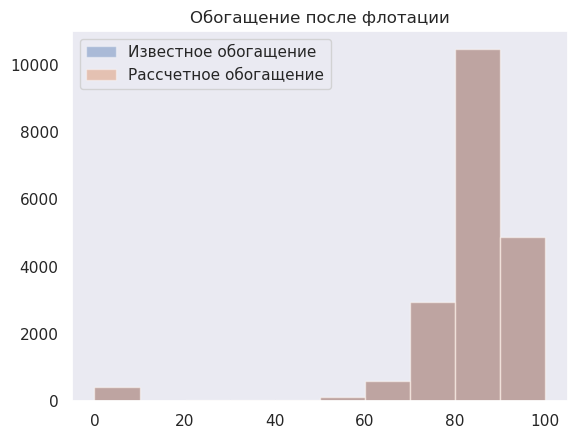

In [6]:
plt.title('Обогащение после флотации')

plt.hist(maes['recovery_we_have'], alpha = 0.4)
plt.hist(maes['recovery_we_calc'], alpha = 0.4)
plt.grid()
plt.legend(['Известное обогащение', 'Рассчетное обогащение'])
plt.show()

In [7]:
print('Известное обогащение\n', maes['recovery_we_have'].describe(), '\n\n'
      'Рассчетное обогащение\n', maes['recovery_we_calc'].describe())

Известное обогащение
 count    19439.000000
mean        83.328587
std         14.148086
min          0.000000
25%         81.037957
50%         86.188892
75%         90.010670
max        100.000000
Name: rougher.output.recovery, dtype: float64 

Рассчетное обогащение
 count    19439.000000
mean        83.328587
std         14.148086
min         -0.000000
25%         81.037957
50%         86.188892
75%         90.010670
max        100.000000
dtype: float64


In [8]:
print(f"MAE обогащения:{mean_absolute_error(maes['recovery_we_have'], maes['recovery_we_calc']):.2f}")

MAE обогащения:0.00


#### Посмотрим на распределение примесей металлов

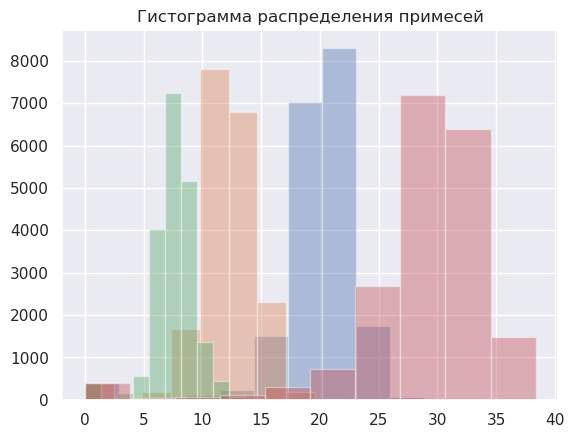

In [9]:
full['rougher.output.concentrate_au'].hist(alpha=0.4)
full['rougher.output.concentrate_ag'].hist(alpha=0.4)
full['rougher.output.concentrate_pb'].hist(alpha=0.4)
full['rougher.output.concentrate_sol'].hist(alpha=0.4)
plt.title("Гистограмма распределения примесей")
plt.show()

In [10]:
print(f"Среднее значение концентрации примесей: {100 - (train['rougher.output.concentrate_au'] + train['rougher.output.concentrate_pb'] + 
       train['rougher.output.concentrate_sol'] + train['rougher.output.concentrate_ag']).mean()}")

Среднее значение концентрации примесей: 32.80370382803537


Обогащение рассчитано правильно. После флотации в сырье в среднем остается еще 33% примеси различных металлов.

### Изучим признаки, недоступные в тестовой выборке. 

In [11]:
print("Признаки, доступные только в трейне")
train.drop(columns=list(set(train.columns) & set(test.columns))).columns

Признаки, доступные только в трейне


Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

Среди недоступных в тестовой выборке данных присутствуют все финальные характеристики:

       'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au'


Концентраты и хвосты после первой промывки:


       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au'
       

Хвосты после второй промывки:


       'secondary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_pb',
       'secondary_cleaner.output.tail_sol',
       'secondary_cleaner.output.tail_au'
       


Рассчетные метрики флотации:

       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio'
       
       

Концентраты и хвосты после флотации:

       'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.output.recovery',
       'rougher.output.tail_ag', 'rougher.output.tail_pb',
       'rougher.output.tail_sol', 'rougher.output.tail_au',

#### Исследуем только те данные, которые присутствуют в обоих выборках:

In [12]:
print(f"Количество доступных признаков: {len(set(train.columns) & set(test.columns))}")
print('\n')
print(f"Количество признаков в тренировочной выборке: {len(train.columns) - 2}") # убираем 2 признака, которые необходимо предсказать

Количество доступных признаков: 53


Количество признаков в тренировочной выборке: 85


В ходе анализа различий тренировочной и тестовой выборок было показано, что в тестовой выборке нехватает 32 признаков.

#### Добавим в тестовую выборку целевые признаки, объединив таблицы full и test по дате

In [13]:
cols_to_add=['rougher.output.recovery', 'final.output.recovery', 'date']
print(test.shape)
test = test.merge(full[cols_to_add], on='date')
test.shape

(5290, 53)


(5290, 55)

## Предобработка данных

Оставим в тренировочной выборке только столбцы, присутствующие в тестовой


In [14]:
cols_to_keep = list(set(test.columns) & set(train.columns))

train = train[cols_to_keep]

Проверим на дубликаты


In [15]:
train.duplicated().sum()

0

In [16]:
test.duplicated().sum()

0

In [17]:
full.duplicated().sum()

0

Посчитаем пропуски


In [18]:
a = train.isna().sum().sort_values(ascending=False)
interpolate_cols = list(a[a>0].index)
a[a>0]

rougher.state.floatbank10_e_air               436
rougher.input.floatbank11_xanthate            428
secondary_cleaner.state.floatbank2_a_air      217
rougher.input.feed_size                       144
primary_cleaner.input.xanthate                100
rougher.input.feed_pb                         100
rougher.input.feed_sol                         78
rougher.input.floatbank11_sulfate              36
primary_cleaner.input.depressant               32
rougher.input.floatbank10_sulfate              29
secondary_cleaner.state.floatbank2_b_air       21
primary_cleaner.input.sulfate                  20
rougher.input.floatbank10_xanthate              8
rougher.input.feed_rate                         8
secondary_cleaner.state.floatbank4_a_air        6
primary_cleaner.state.floatbank8_a_air          4
secondary_cleaner.state.floatbank3_a_air        4
primary_cleaner.state.floatbank8_b_air          4
primary_cleaner.state.floatbank8_d_air          3
primary_cleaner.state.floatbank8_c_air          2


Все пропущенные значения должны быть похожи на имеющиеся данные из соседних дней. Интерполируем данные, исходя из соседних значений.

In [19]:
test = test.sort_values(by=['date'])
test[interpolate_cols] = test[interpolate_cols].interpolate(method='nearest')

train = train.sort_values(by=['date'])
train[interpolate_cols] = train[interpolate_cols].interpolate(method='nearest')

In [20]:
train.isna().sum()

rougher.state.floatbank10_d_level             0
primary_cleaner.state.floatbank8_b_air        0
secondary_cleaner.state.floatbank3_a_level    0
primary_cleaner.state.floatbank8_c_air        0
rougher.state.floatbank10_f_air               0
primary_cleaner.input.depressant              0
primary_cleaner.state.floatbank8_c_level      0
rougher.state.floatbank10_b_level             0
secondary_cleaner.state.floatbank3_b_level    0
secondary_cleaner.state.floatbank5_b_air      0
rougher.input.feed_sol                        0
secondary_cleaner.state.floatbank3_a_air      0
primary_cleaner.state.floatbank8_d_air        0
rougher.input.feed_ag                         0
rougher.state.floatbank10_a_air               0
rougher.state.floatbank10_b_air               0
rougher.state.floatbank10_d_air               0
primary_cleaner.state.floatbank8_a_air        0
secondary_cleaner.state.floatbank4_b_air      0
secondary_cleaner.state.floatbank4_b_level    0
rougher.input.floatbank10_xanthate      

In [21]:
test.isna().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

## Анализ данных

#### Анализ изменения концентрации металлов на различных этапах очистки

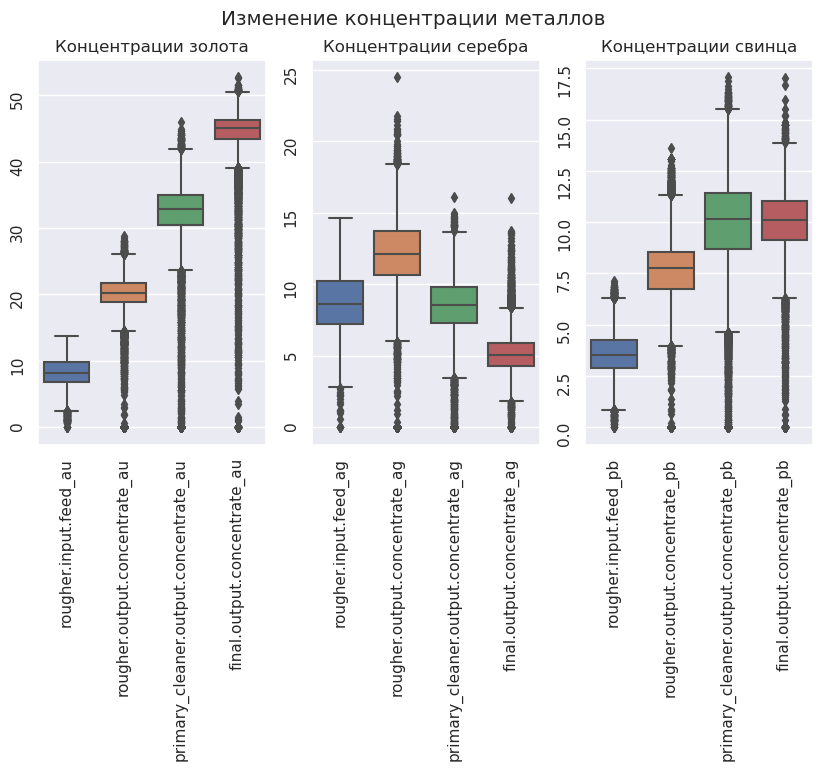

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

fig.suptitle('Изменение концентрации металлов')

ax1.set_title('Концентрации золота')
ax1.tick_params(labelrotation=90,)
sns.boxplot(data = full[['rougher.input.feed_au', 
                      'rougher.output.concentrate_au', 
                      'primary_cleaner.output.concentrate_au',
                       'final.output.concentrate_au']],
           ax=ax1)

ax2.set_title('Концентрации серебра')
ax2.tick_params(labelrotation=90)
sns.boxplot(data = full[['rougher.input.feed_ag', 
                      'rougher.output.concentrate_ag', 
                      'primary_cleaner.output.concentrate_ag',
                       'final.output.concentrate_ag']],
           ax=ax2)

ax3.set_title('Концентрации свинца')
ax3.tick_params(labelrotation=90)
sns.boxplot(data = full[['rougher.input.feed_pb', 
                      'rougher.output.concentrate_pb', 
                      'primary_cleaner.output.concentrate_pb',
                       'final.output.concentrate_pb']],
               ax=ax3)
fig.show()


* Концентрация золота растет после кождого этапа
* Концентрация серебра растет после флотации, затем падает с каждым шагом очистки
* Концентрация свинца растет после флотации и первой очистки, после второй очистки она не меняется

#### Сравним размеры гранул в тренировочной и тестовой выборках

 Mann–Whitney U Test: statistic=39683249.00, p-value=8.705916586797957e-11


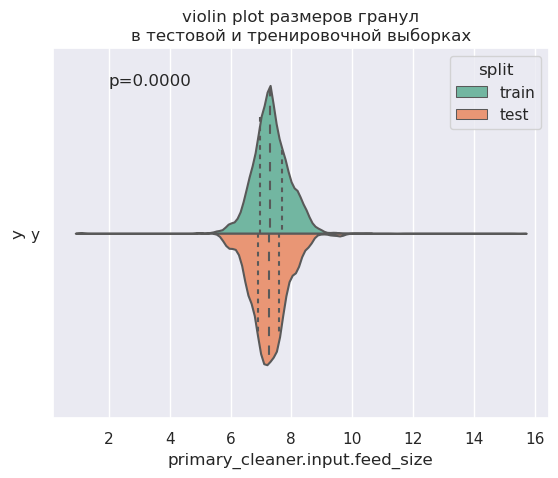

In [23]:
# разделим full на тест и трейн
full.loc[full['date'].isin(test['date']), 'split'] = 'test'      
full.loc[full['date'].isin(train['date']), 'split'] = 'train'      
full['y'] = 'y'
# подготовим векторы для сравнения
a = full.loc[full['split']=='train', 'primary_cleaner.input.feed_size']
b = full.loc[full['split']=='test', 'primary_cleaner.input.feed_size']
# непараметрический критерий 
stat, p_value = mannwhitneyu(a, b)
print(f" Mann–Whitney U Test: statistic={stat:.2f}, p-value={p_value}")
# график
sns.violinplot(data=full, 
              y='y',
              x='primary_cleaner.input.feed_size',
              hue='split', split=True, inner="quartile",
              palette="Set2"
              )
plt.text(s=f"p={p_value:.4f}", y=-0.4, x=2)
plt.title('violin plot размеров гранул\nв тестовой и тренировочной выборках')

None

Мы видим, что распределения размеров гранул в тестовой и тренировочной выборках очень похожи и данные можно использовать для обучения модели, несмотря на то, что статистически они различаются. 

#### На боксплотах видно много выбросов. Нужно изучить их внимательнее

Посмотрим на выбросы в суммарых концентрациях металлов на каждом этапе производства

In [24]:
# считаем суммы
def sum_material(data):
    data['summ_roughter_input'] = ( data['rougher.input.feed_ag']+
                                    data['rougher.input.feed_pb']+
                                    data['rougher.input.feed_au']+
                                    data['rougher.input.feed_sol'] )

    data['summ_roughter_output'] = (
                                        data['rougher.output.concentrate_ag'] + 
                                        data['rougher.output.concentrate_pb'] +
                                        data['rougher.output.concentrate_sol'] +
                                        data['rougher.output.concentrate_au'])

    data['summ_final_output'] = (
        data['final.output.concentrate_ag'] +
        data['final.output.concentrate_pb'] +
        data['final.output.concentrate_sol'] +
        data['final.output.concentrate_au']
    )
    return data

In [25]:
full = sum_material(full)

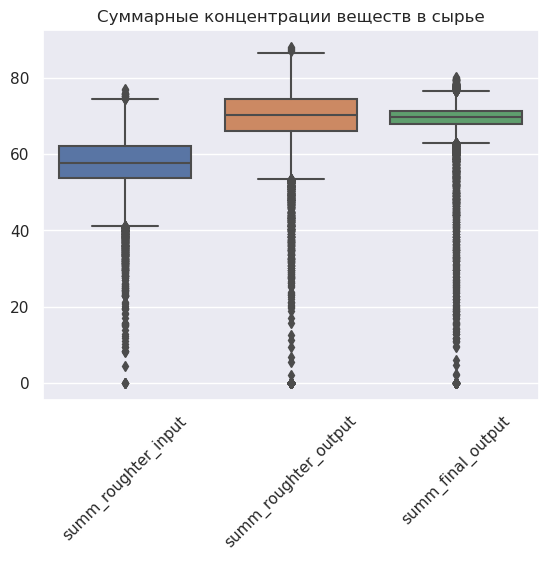

In [26]:
sns.boxplot(data=full[['summ_roughter_input',
                      'summ_roughter_output',
                      'summ_final_output']])
plt.title('Суммарные концентрации веществ в сырье')
plt.xticks(rotation=45)
None

Суммарные концентрации веществ содержат много выбросов. Большинство из них содержатся в низких значениях. Чтобы модель лучше обучилась, необходимо откинуть сильно выбивающиеся значения из тренировочной выборки. Для этого используем метод интерквантильного размаха. Для фильтрации значений будем использовать признаки, доступные в тренировочной выборки.

In [27]:
# посчитаем доступную метрику
train['summ_roughter_input'] = ( train['rougher.input.feed_ag']+
                                 train['rougher.input.feed_pb']+
                                 train['rougher.input.feed_au']+
                                 train['rougher.input.feed_sol'] )

In [28]:
# считаем IQR

q25_r_input, q75_r_input = (np.percentile(train['summ_roughter_input'], 25),
                            np.percentile(train['summ_roughter_input'], 75))
print('Сырье')
print(f"Квантили: {q25_r_input:.2f}, {q75_r_input:.2f}")
iqr_r_input = q75_r_input - q25_r_input
print(f'Размах: {iqr_r_input:.2f}')
iqr_r_input_cutoff = iqr_r_input * 1.8
print(f'Пороговое значение: {iqr_r_input_cutoff:.2f}')

Сырье
Квантили: 52.57, 60.76
Размах: 8.19
Пороговое значение: 14.75


In [29]:
# фильтр по сырью
train_new = train[(train['summ_roughter_input'] < (q75_r_input + iqr_r_input_cutoff)) &
                   (train['summ_roughter_input'] > (q25_r_input - iqr_r_input_cutoff))]

In [30]:
print(f"Доля оставшихся значений: {len(train_new) / len(train)}")
print(f"Количесво оставшихся строк: {len(train_new)}")

Доля оставшихся значений: 0.9830376705067496
Количесво оставшихся строк: 13909


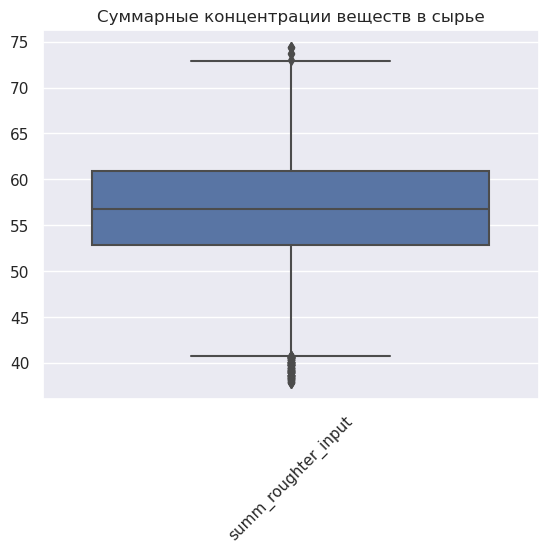

In [31]:
sns.boxplot(data=train_new[['summ_roughter_input']])
plt.title('Суммарные концентрации веществ в сырье')
plt.xticks(rotation=45)
None

Даже после достаточно жесткой фильтрации по выбросам, в тренировочной выборке осталось 98% наблюдений.

## Модель

### Функция для подсчета sMAPE

Создадим функцию для подсчета Symmetric mean absolute percentage error


$$ SMAPE = \frac{1}{N} \sum_ {N} ^ {i=1} \frac{|y - \grave{y}|}{(|y|+|\grave{y}|)/2} * 100% $$

$$ final SMAPE = SMAPE(roughter) * 25%
+ SMAPE(final) * 75% $$

In [32]:
def total_smape(y_true,y_pred):
    numerator = np.abs(y_true - y_pred) # числитель
    denominator = (np.abs(y_true) + np.abs(y_pred))/2 # знаменатель
    smape = ((numerator/denominator)*100).sum() / len(y_pred)
    return 0.25*smape[0] + 0.75*smape[1]
# чем ближе к 0, тем лучше
smape_scorer = make_scorer(total_smape, greater_is_better=False)

### Разобьем данные 

In [33]:
X_train = train_new.drop(columns=['rougher.output.recovery', 
                                 'final.output.recovery','date'])
y_train = train_new[['rougher.output.recovery', 
                    'final.output.recovery']]

X_test = test.drop(columns=['rougher.output.recovery', 
                            'final.output.recovery', 'date'])
y_test = test[['rougher.output.recovery', 
               'final.output.recovery']]

In [34]:
X_test['summ_roughter_input'] = (X_test['rougher.input.feed_ag']+
                                 X_test['rougher.input.feed_pb']+
                                 X_test['rougher.input.feed_au']+
                                 X_test['rougher.input.feed_sol'] )
X_test = X_test[X_train.columns]

### Выберем признаки для обучения модели

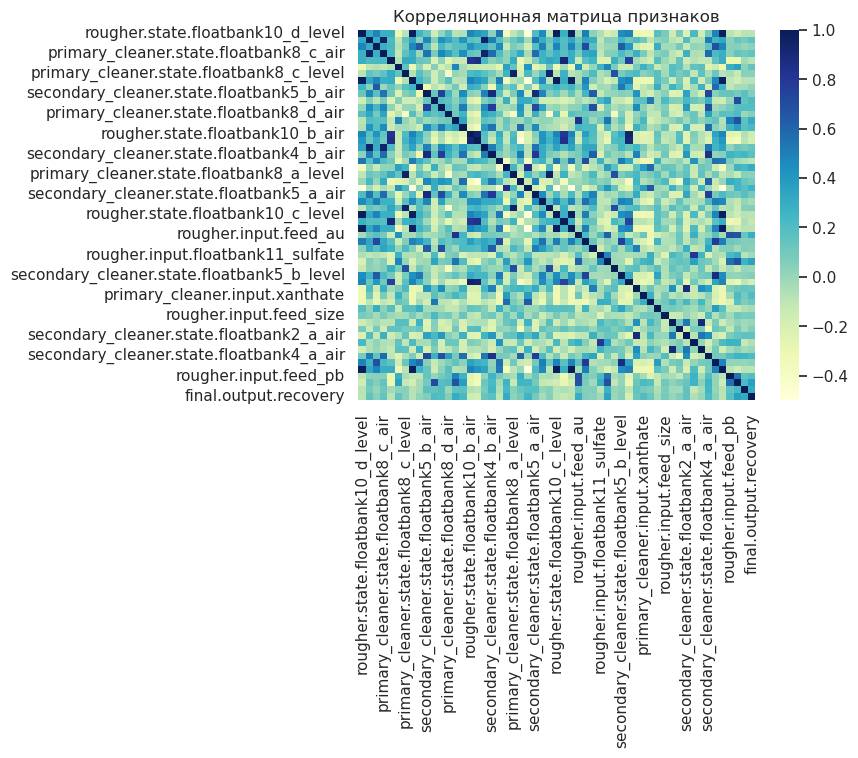

In [35]:
train_corr = X_train.merge(train_new[['rougher.output.recovery', 'final.output.recovery']],right_index=True,left_index=True).corr()

plt.title("Корреляционная матрица признаков")
sns.heatmap(train_corr,
           cmap="YlGnBu")
plt.show()

Существуют признаки с сильной корреляцией относительно друг друга. При этом не все признаки коррелируют с таргетом. Нужно выбрать значимые признаки.

Посмотрим на коэффициенты корреляции.

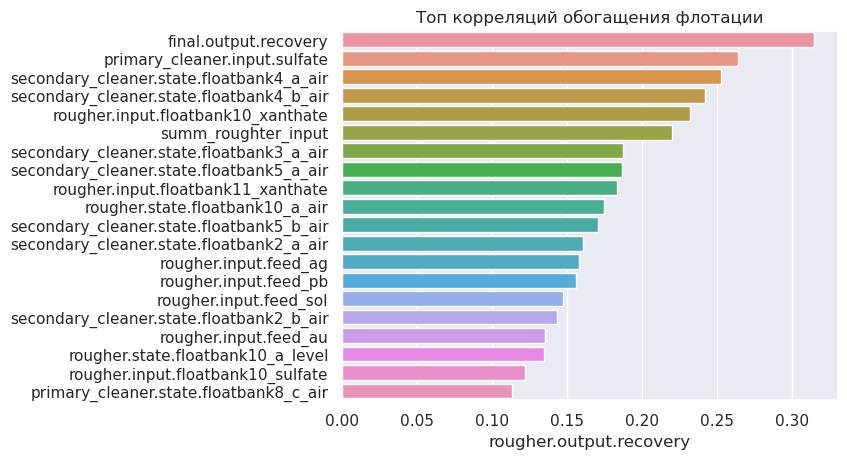

In [36]:
corr_top = train_corr['rougher.output.recovery'].abs().sort_values(ascending=False)[1:21]

plt.title("Топ корреляций обогащения флотации")
sns.barplot(x=corr_top, y=corr_top.index)
plt.show()

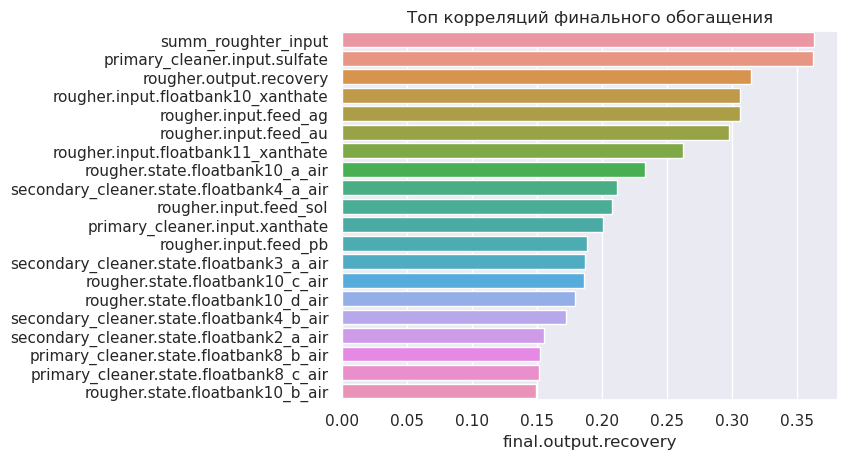

In [37]:
corr_top2 = train_corr['final.output.recovery'].abs().sort_values(ascending=False)[1:21]

plt.title("Топ корреляций финального обогащения")
sns.barplot(x=corr_top2, y=corr_top2.index)
plt.show()

In [38]:
# оставляем прересекающиеся признаки
features_to_use = list((set(corr_top2.index) | set(corr_top2.index)))
features_to_use.remove('rougher.output.recovery')
X_train, X_test = X_train[features_to_use], X_test[features_to_use]
display(X_train.head(), X_train.shape)

,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_c_air,rougher.input.feed_sol,secondary_cleaner.state.floatbank3_a_air,rougher.input.feed_ag,rougher.state.floatbank10_a_air,rougher.state.floatbank10_b_air,rougher.state.floatbank10_d_air,secondary_cleaner.state.floatbank4_b_air,rougher.input.floatbank10_xanthate,summ_roughter_input,rougher.input.floatbank11_xanthate,rougher.input.feed_au,primary_cleaner.input.sulfate,rougher.state.floatbank10_c_air,primary_cleaner.input.xanthate,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank4_a_air,rougher.input.feed_pb
0,1551.434204,1549.873901,36.808594,23.961798,6.100378,999.706909,1603.011353,1598.937256,12.099931,6.007990,51.680034,6.005818,6.486150,127.092003,1602.375000,0.988759,25.853109,14.016835,2.284912
1,1575.950626,1575.994189,35.753385,23.970550,6.161113,1000.286398,1600.754587,1600.527589,11.950531,6.005766,50.659114,6.012594,6.478583,125.629232,1600.479580,1.002663,25.880539,13.992281,2.266033
2,1600.386685,1602.003542,35.971630,23.913535,6.116455,999.719565,1599.337330,1599.849325,11.912783,6.197377,50.609929,6.204633,6.362222,123.819808,1599.672797,0.991265,26.005245,14.015015,2.159622
3,1600.659236,1600.304144,36.862241,23.966838,6.043309,999.814770,1600.059442,1597.725177,11.999550,6.203177,51.061546,6.196578,6.118189,122.270188,1600.012842,0.996739,25.942508,14.036510,2.037807
4,1601.437854,1599.581894,34.347666,23.985703,6.060915,999.678690,1600.208824,1599.759049,11.953070,6.198826,47.859163,6.194897,5.663707,117.988169,1600.357732,1.009869,26.024787,14.027298,1.786875


(13909, 19)

### Выбор модели и подбор гиперпараметров

Создадим пайплайн для кроссвалидации выбранных моделей.

In [39]:
def grid_search_cross_val(model, params, cv=12, n_iter=5, scoring=smape_scorer, X_train=X_train, y_train=y_train):

    # get best parameters
    preprocessor = StandardScaler()
    grid_search = RandomizedSearchCV(model, params, scoring=scoring, verbose=1, n_iter=n_iter, cv=cv)
    my_pipeline = Pipeline(steps = [('preprocess', preprocessor),
                                    ('grid_search', grid_search)])
    my_pipeline.fit(X_train, y_train)

    return my_pipeline, [my_pipeline['grid_search'].best_estimator_, my_pipeline['grid_search'].best_score_]

In [40]:
%%time
trees_pipeline, trees = grid_search_cross_val(RandomForestRegressor(random_state=12, n_jobs=-1), 
                              {'max_depth':[3,5,10,None],
                               'n_estimators':[10,100,200],
                               'max_features':[1,3,5,7],
                               'min_samples_leaf':[1,2,3],
                               'min_samples_split':[1,2,3]},
                              )

trees

Fitting 12 folds for each of 5 candidates, totalling 60 fits
CPU times: user 4.32 s, sys: 712 ms, total: 5.03 s
Wall time: 14.9 s


[RandomForestRegressor(max_depth=5, max_features=7, min_samples_leaf=2,
                       min_samples_split=3, n_estimators=10, n_jobs=-1,
                       random_state=12),
 -9.609321840263041]

In [41]:
%%time
knn_pipeline, knn = grid_search_cross_val(KNeighborsRegressor(), {"n_neighbors" : range(1,11), "algorithm": ['ball_tree', 'kd_tree', 'brute']})
knn

Fitting 12 folds for each of 5 candidates, totalling 60 fits
CPU times: user 9.76 s, sys: 500 ms, total: 10.3 s
Wall time: 6.64 s


[KNeighborsRegressor(algorithm='brute', n_neighbors=10), -10.453289366352356]

In [42]:
%%time
ridge_pipeline, ridge = grid_search_cross_val(Ridge(random_state=12), {"alpha" : np.arange(0.01, 1, 0.05)})
ridge

Fitting 12 folds for each of 5 candidates, totalling 60 fits
CPU times: user 1.05 s, sys: 2.3 s, total: 3.35 s
Wall time: 445 ms


[Ridge(alpha=0.6100000000000001, random_state=12), -10.259814019581588]

In [43]:
%%time
xgb_pipeline, xgb = grid_search_cross_val(XGBRegressor(random_state=12, n_jobs=0), {"n_estimators" : range(200, 800, 50), 
                                                                                    "max_depth" :  range(5,50,5),
                                                                                    "eta" : np.arange(0.001, 0.1, 0.01),
                                                                                    "subsample" : np.arange(0.1, 1, 0.1),
                                                                                    "colsample_bytree" : np.arange(0.1, 1, 0.1)},
                                                                                     cv=5)
xgb

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: user 1h 38min 50s, sys: 8.89 s, total: 1h 38min 59s
Wall time: 12min 35s


[XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.2, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.05099999999999999,
              eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=45,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=250,
              n_jobs=0, num_parallel_tree=None, ...),
 -10.346732726603054]

In [44]:
dummy_regr_pipeline, dummy_regr = grid_search_cross_val(DummyRegressor(), {"strategy": ["mean", "median", "quantile", "constant"]})
dummy_regr

Fitting 12 folds for each of 4 candidates, totalling 48 fits


[DummyRegressor(strategy='median'), -10.976548311424912]

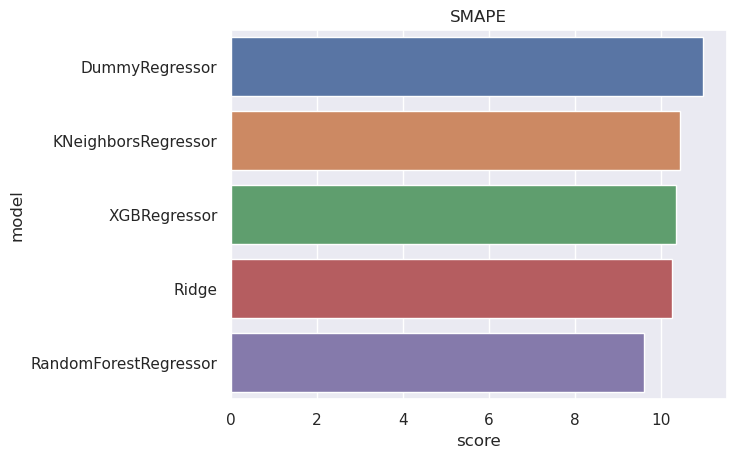

In [45]:
scores_map = pd.DataFrame([trees, knn, ridge, dummy_regr, xgb], columns=["model", "score"]).sort_values("score")
scores_map["model"] = scores_map["model"].astype("str").str.split("(", expand=True)[0]
scores_map["score"] = scores_map["score"]*(-1)

plt.title("SMAPE")
sns.barplot(x=scores_map["score"], y=scores_map["model"])
plt.show()

In [46]:
scores_map

,model,score
3,DummyRegressor,10.976548
1,KNeighborsRegressor,10.453289
4,XGBRegressor,10.346733
2,Ridge,10.259814
0,RandomForestRegressor,9.609322


Лучшие средние значения SMAPE у модели RandomForest. 

### Выберем RandomForest для проверим на тестовой выборке

In [47]:
# RF
y_predict = trees_pipeline.predict(X_test)
print(f"SMAPE RF на тестовой выборке: {total_smape(y_test, y_predict):.2f}")

SMAPE RF на тестовой выборке: 9.04


In [48]:
# Сравним SMAPE с дамми моделью
dummy_predict = dummy_regr_pipeline.predict(X_test)
print(f"SMAPE дамми на тестовой выборке: {total_smape(y_test, dummy_predict):.2f}")

SMAPE дамми на тестовой выборке: 9.43


## Вывод

* Изменения показателей концентратов золота говорят о том, что каждый шаг обработки руды способствует обогащению.
* В результате работы нам удалось получить модель на основе случайного леса с показателем SMAPE 9.04. Этот показатель меньше показателя дамми модели на 0.39.
* При проверке размера гранул, мы обнаружили, что их средний размер в тестовой и тренировочной выборках статистически различается. Возможно, из-за этого обучение моделей показало такой результат.
